In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import pathlib
data_dir = pathlib.Path(pathlib.Path.cwd()) / "data"
print(data_dir)

C:\Users\mcs52\Desktop\CS3840-Final-Project\data


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1289


In [5]:
batch_size = 32
img_height = 300
img_width = 300

train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=.5,
subset="training",
seed=123,
image_size = (img_height, img_width),
batch_size = batch_size)

Found 1289 files belonging to 2 classes.
Using 645 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
    validation_split=.5,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1289 files belonging to 2 classes.
Using 644 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['fake', 'real']


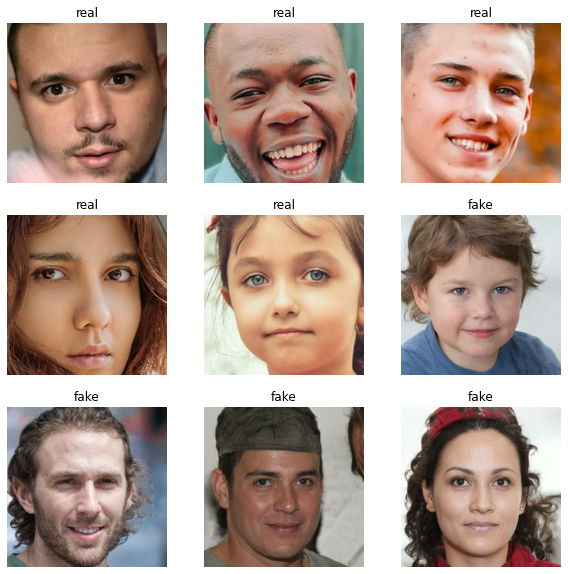

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)


normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))



0.0 0.8196079


In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
21/21 [==============================] - 5s 61ms/step - loss: 1.2293 - accuracy: 0.6217 - val_loss: 0.3573 - val_accuracy: 0.9379
Epoch 2/10
21/21 [==============================] - 1s 39ms/step - loss: 0.1508 - accuracy: 0.9721 - val_loss: 0.0388 - val_accuracy: 0.9829
Epoch 3/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0684 - accuracy: 0.9845 - val_loss: 0.0362 - val_accuracy: 0.9891
Epoch 4/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 5/10
21/21 [==============================] - 1s 37ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0213 - val_accuracy: 0.9938
Epoch 6/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0033 - accuracy: 0.9984 - val_loss: 0.0166 - val_accuracy: 0.9938
Epoch 7/10
21/21 [==============================] - 1s 37ms/step - loss: 5.1041e-04 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9969
Epoch 8/1

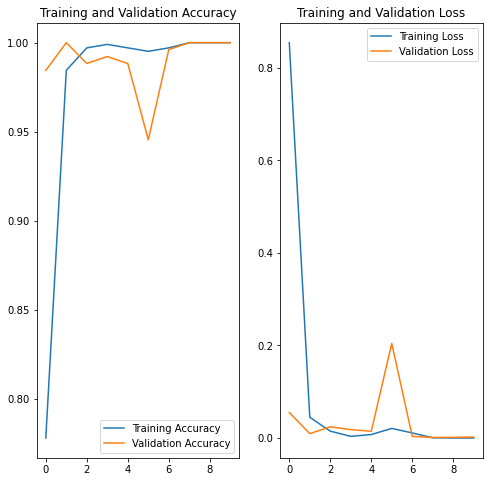

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


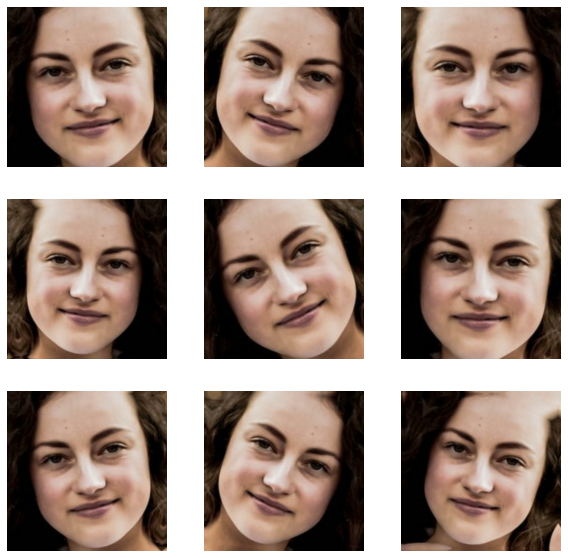

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [20]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

In [15]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
21/21 [==============================] - 1s 39ms/step - loss: 1.8468e-04 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9969
Epoch 2/15
21/21 [==============================] - 1s 35ms/step - loss: 1.7457e-04 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9969
Epoch 3/15
21/21 [==============================] - 1s 37ms/step - loss: 1.5088e-04 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 0.9969
Epoch 4/15
21/21 [==============================] - 1s 37ms/step - loss: 1.2709e-04 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9969
Epoch 5/15
21/21 [==============================] - 1s 39ms/step - loss: 9.9192e-05 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 0.9969
Epoch 6/15
21/21 [==============================] - 1s 38ms/step - loss: 8.7783e-05 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9969
Epoch 7/15
21/21 [==============================] - 1s 38ms/step - loss: 7.9874e-05 - accuracy: 1.0000 - val_loss: 0.0106 - val_ac